In [1]:
import pandas as pd
from astropy.stats import sigma_clipped_stats
from astropy.stats import SigmaClip
import astropy

import numpy as np

import matplotlib.pyplot as plt

In [2]:
import ccdproc as ccdp

# Import necessary packages to do aperture photometry
from photutils import aperture_photometry
import photutils

In [3]:
light_file_collection = ccdp.ImageFileCollection('../reduced-lights_2022_03_20')
data = [i for i in light_file_collection.data()]

In [10]:
test = data[0]

In [73]:
from photutils.detection import DAOStarFinder

def aperture_photometry_function(array, fwhm = 8.0, threshold = 10000):
    mean, median, std = sigma_clipped_stats(array, sigma=2.5)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)
    sources = daofind(array - median)
    local_positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    local_apertures = CircularAperture(local_positions, r=4.)
    local_result = aperture_photometry(test, local_apertures)
    return local_result

In [74]:
def excluding_duplicates(df):
    #Taking initial comparison values from first row
    xcenter,ycenter = df.iloc[0][['xcenter','ycenter']]
    #Including first row in result
    filters = [True]

    #Skipping first row in comparisons
    for index, row in df.iloc[1:].iterrows():
        if 0.99*xcenter <= row['xcenter'] <= 1.01*xcenter and 0.99*ycenter <= row['ycenter'] <= 1.01*ycenter:
            filters.append(False)
        else:
            filters.append(True)
            # Updating values to compare based on latest accepted row
            xcenter = row['xcenter']
            ycenter = row['ycenter']

    result = df.loc[filters]
    return result.reset_index(drop = True)


def image_trimmer(positions, array):
    image_size = array.shape
    x_trim = image_size[1] * 0.05
    y_trim = image_size[0] * 0.05
    if isinstance(positions, astropy.table.table.QTable):
        positions = positions.to_pandas().drop('id', axis = 'columns')
    else:
        positions = pd.DataFrame(positions, columns = ['xcenter', 'ycenter'])
    positions = positions[(positions['xcenter'] - x_trim > 0) & (positions['xcenter'] + x_trim < image_size[1])]
    positions = positions[(positions['ycenter'] - y_trim > 0) & (positions['ycenter'] + y_trim < image_size[0])]
    return positions



In [60]:
values_fwhm = np.arange(5, 30, 1)
values_counts = values_fwhm*1000

detected_stars_fwhm = [len(excluding_duplicates(image_trimmer(aperture_photometry_function(test, fwhm = fwhm), test))) for fwhm in values_fwhm]
detected_stars_counts = [len(excluding_duplicates(image_trimmer(aperture_photometry_function(test, threshold = count),test))) for count in values_counts]

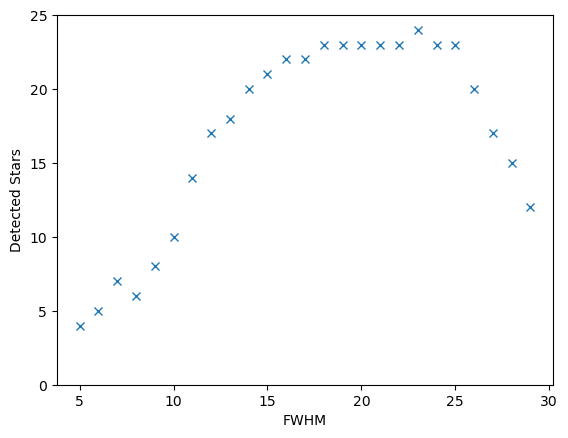

In [65]:
plt.plot(values_fwhm, detected_stars_fwhm, 'x')
plt.xlabel('FWHM')
plt.ylabel('Detected Stars')
plt.ylim(0,)
plt.savefig('FWHM vs Detected Stars')

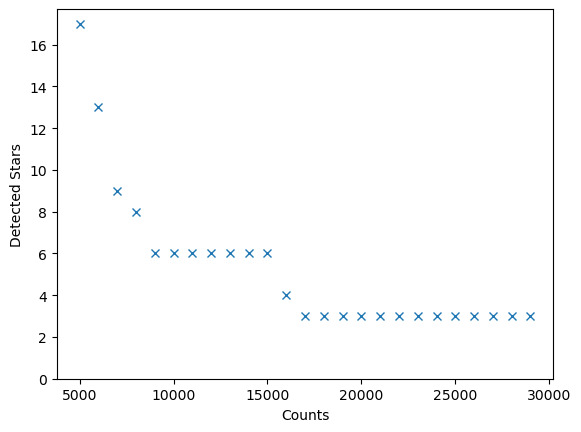

In [66]:
plt.plot(values_counts, detected_stars_counts, 'x')
plt.xlabel('Counts')
plt.ylabel('Detected Stars')
plt.ylim(0,)
plt.savefig('Counts vs Detected Stars')

In [75]:
aperture, positions = excluding_duplicates(image_trimmer(aperture_photometry_function(test, fwhm = 22, threshold = 20000), test))

ValueError: 2 columns passed, passed data had 14 columns

In [ ]:
from convenience_functions import show_image, find_magnitude

show_image(test, cmap = 'gray')
aperture.plot(color='blue', lw=1.5, alpha=0.5);

In [2]:
import numpy as np

import matplotlib.pyplot as plt

from astropy.visualization import SqrtStretch

from astropy.visualization.mpl_normalize import ImageNormalize

from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

apertures = CircularAperture(positions, r=4.)

norm = ImageNormalize(stretch=SqrtStretch())

NameError: name 'sources' is not defined

In [ ]:
from convenience_functions import show_image, find_magnitude

show_image(test, cmap = 'twilight')
apertures.plot(color='black', lw=1.5, alpha=0.5);

In [ ]:
from photutils.aperture import aperture_photometry

aperture_photometry(test, apertures)

In [11]:
def aperture_photometry_function(array):
    mean, median, std = sigma_clipped_stats(array, sigma=2.5)
    daofind = DAOStarFinder(fwhm=3.0, threshold=10000)
    sources = daofind(array - median)
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=4.)
    result = aperture_photometry(test, apertures)
    return result

In [ ]:
aperture_dict = dict()
for index, array in enumerate(data):
    aperture_dict[index] = aperture_photometry_function(array)

In [ ]:
for key in aperture_dict.keys():
    aperture_dict[key] = aperture_dict[key].to_pandas()
    aperture_dict[key] = aperture_dict[key].sort_values('aperture_sum', ascending = False)

In [14]:
from astroquery.astrometry_net import AstrometryNet

ast = AstrometryNet

In [15]:
from astropy.table import Table
from astroquery.astrometry_net import AstrometryNet

ast = AstrometryNet()
ast.api_key = 'vjzfuceldhqgdzxe'

wcs_header = ast.solve_from_image('../RV_Uma/Luminance/RV_Uma_Light_Luminance_16_secs_001.fits')

FileNotFoundError: [Errno 2] No such file or directory: '../RV_Uma/Luminance/RV_Uma_Light_Luminance_16_secs_001.fits'

In [ ]:
print('RA', wcs_header['CRVAL1'])
print('DEC', wcs_header['CRVAL2'])

In [16]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64
1,3760.9510781302442,390.79348047386173,0.45777457013086753,0.14182157978156068,0.07337406151425259,121,0.0,55498.14698274361,7.888861202166443,-2.242535787709696
2,611.4051246893503,1054.8873224373185,0.39968555597787164,0.3713863494414976,-0.33343467248726955,121,0.0,10503.052146286282,1.6886557707584442,-0.5688528212389392
3,344.8971667208177,1061.206798100374,0.31958500167717574,0.10880369865111222,-0.8689848729458001,121,0.0,67302.1559257104,6.943117100136566,-2.1038862249353767
4,342.43888996136326,1062.977150888977,0.32486425381812173,0.3953728667038085,0.3001285530561121,121,0.0,67616.163619317,7.550350879642359,-2.194917836540393
5,347.982209745495,1064.6208641500464,0.3221124256743448,0.11262654067387526,-0.1444620886688238,121,0.0,66872.51499277673,8.64447862137935,-2.3418470114666574
6,4603.341106765038,1224.9910600552184,0.4590274089760858,-0.03111016978605498,0.10262407575062453,121,0.0,23934.26742012596,3.2632350943482598,-1.2841209073476132
7,4586.5293207632085,1228.5566383211892,0.3905328592786153,-0.008812350774506624,-0.022855600221072317,121,0.0,13708.515698199479,1.9513350485283274,-0.725829612791955
8,2295.4230049807456,1798.6168377155636,0.4393629729470208,-0.09099883347674934,-0.12862025114547593,121,0.0,11225.085503881564,1.5111941231324306,-0.4483006399840872
9,2292.9457242008116,1799.2024806535699,0.48546757561939846,-0.2567862238713261,-0.44182335273940365,121,0.0,10745.817241342611,1.4473582543241592,-0.4014401056461244


In [17]:
sources['xcentroid']
sources['ycentroid']

390.79348047386173
1054.8873224373185
1061.206798100374
1062.977150888977
1064.6208641500464
1224.9910600552184
1228.5566383211892
1798.6168377155636
1799.2024806535699
2671.3095582539736
2672.511719905114


TODO

DO APERTURE PHOTOMETRY ON THE STARS OF THE FIRST IMAGE

PASS EVERYTHING TO SKY COORDINATES

RUN APERTURE PHOTOMETRY ON EVERY OTHER IMAGE USING SKY COORDINATES

In [18]:
# def aperture_photometry_function_v2(array):

aperture = CircularAperture(positions, r=4)
annulus_aperture = CircularAnnulus(positions, r_in=8, r_out=15)

In [19]:
sigclip = SigmaClip(sigma=2.5, maxiters=5)
aper_stats = ApertureStats(test, aperture, sigma_clip=None)
bkg_stats = ApertureStats(test, annulus_aperture, sigma_clip=sigclip)

In [20]:
bkg_median = bkg_stats.median
print(bkg_median)

[1385.63205281  481.92068242 5100.26797193 4569.53595379 4595.41325342
 1228.10124838  735.94107528  626.67539892  617.4009283  6533.75712086
 4857.57401358 5473.96613935  524.99615398 1220.34176308]


In [21]:
from photutils.aperture import aperture_photometry
phot_table = aperture_photometry(test, aperture)
for col in phot_table.colnames:
   phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 3760.9511 390.79348    2060793.1
  2 611.40512 1054.8873    424064.93
  3 344.89717 1061.2068      3389946
  4 342.43889 1062.9772    3398866.3
  5 347.98221 1064.6209    3362385.3
  6 4603.3411 1224.9911    910001.35
  7 4586.5293 1228.5566    546220.12
  8  2295.423 1798.6168    484107.33
  9 2292.9457 1799.2025    474696.73
 10 2138.8653 2671.3096    3176835.3
 11 2133.0642 2672.5117    3184991.7
 12 2140.3977 2674.1005    3150079.9
 13 383.53468 3314.7202    410023.42
 14  284.8266 3357.1609    1312416.3


In [22]:
aperture_area = aper_stats.sum_aper_area.value
print(aperture_area)

[50.26548246 50.26548246 50.26548246 50.26548246 50.26548246 50.26548246
 50.26548246 50.26548246 50.26548246 50.26548246 50.26548246 50.26548246
 50.26548246 50.26548246]


In [23]:
total_bkg = bkg_median * aperture_area
phot_bkgsub = phot_table['aperture_sum'] - total_bkg

In [24]:
phot_table['total_bkg'] = total_bkg
phot_table['aperture_sum_bkgsub'] = phot_bkgsub
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  aperture_sum total_bkg aperture_sum_bkgsub
       pix       pix                                              
--- --------- --------- ------------ --------- -------------------
  1 3760.9511 390.79348    2060793.1 69649.464           1991143.6
  2 611.40512 1054.8873    424064.93 24223.976           399840.96
  3 344.89717 1061.2068      3389946 256367.43           3133578.5
  4 342.43889 1062.9772    3398866.3 229689.93           3169176.4
  5 347.98221 1064.6209    3362385.3 230990.66           3131394.6
  6 4603.3411 1224.9911    910001.35 61731.102           848270.25
  7 4586.5293 1228.5566    546220.12 36992.433           509227.68
  8  2295.423 1798.6168    484107.33 31500.141           452607.19
  9 2292.9457 1799.2025    474696.73 31033.956           443662.78
 10 2138.8653 2671.3096    3176835.3 328422.45           2848412.8
 11 2133.0642 2672.5117    3184991.7  244168.3           2940823.4
 12 2140.3977 2674.1005    3150079.9 275151.55           28749

In [25]:
type(positions)

numpy.ndarray

In [26]:
image_size = test.shape
x_trim = image_size[1] * 0.05
y_trim = image_size[0] * 0.05
positions = pd.DataFrame(positions, columns = ['xcenter', 'ycenter'])

In [27]:
positions = positions[(positions['xcenter'] - x_trim > 0) & (positions['xcenter'] + x_trim < image_size[1])]
positions = positions[(positions['ycenter'] - y_trim > 0) & (positions['ycenter'] + y_trim < image_size[0])]

In [28]:
positions

,xcenter,ycenter
0,3760.951078,390.793480
1,611.405125,1054.887322
2,344.897167,1061.206798
3,342.438890,1062.977151
4,347.982210,1064.620864
7,2295.423005,1798.616838
8,2292.945724,1799.202481
9,2138.865264,2671.309558
10,2133.064206,2672.511720
11,2140.397728,2674.100483


In [29]:
def image_trimmer(positions, array):
    image_size = array.shape
    x_trim = image_size[1] * 0.05
    y_trim = image_size[0] * 0.05
    positions = pd.DataFrame(positions, columns = ['xcenter', 'ycenter'])
    positions = positions[(positions['xcenter'] - x_trim > 0) & (positions['xcenter'] + x_trim < image_size[1])]
    positions = positions[(positions['ycenter'] - y_trim > 0) & (positions['ycenter'] + y_trim < image_size[0])]
    return positions

In [31]:
trimmed_positions = image_trimmer(positions, test)

In [41]:
def excluding_duplicates(df):
    #Taking initial comparison values from first row
    xcenter,ycenter = df.iloc[0][['xcenter','ycenter']]
    #Including first row in result
    filters = [True]

    #Skipping first row in comparisons
    for index, row in df.iloc[1:].iterrows():
        if 0.99*xcenter <= row['xcenter'] <= 1.01*xcenter and 0.99*ycenter <= row['ycenter'] <= 1.01*ycenter:
            filters.append(False)
        else:
            filters.append(True)
            # Updating values to compare based on latest accepted row
            xcenter = row['xcenter']
            ycenter = row['ycenter']

    result = df.loc[filters]
    return result.reset_index(drop = True)

In [42]:
excluding_duplicates(trimmed_positions)

,xcenter,ycenter
0,3760.951078,390.793480
1,611.405125,1054.887322
2,344.897167,1061.206798
3,2295.423005,1798.616838
4,2138.865264,2671.309558
5,383.534684,3314.720245
